# Phân Loại Dữ Liệu - Logistic Regression
## Dự đoán Osteoporosis dựa trên các yếu tố lối sống

**Mục tiêu:** Xây dựng mô hình Logistic Regression để dự đoán nguy cơ loãng xương (Osteoporosis) dựa trên các yếu tố lối sống và đặc điểm cá nhân.

**Dataset:** Lifestyle Factors Influencing Osteoporosis (1,958 samples, 30 features)


In [28]:
# Cài đặt các thư viện (nếu chưa có)
%pip install -q -r requirements.txt

print("Hoàn tất kiểm tra/cài đặt thư viện!")


Note: you may need to restart the kernel to use updated packages.
Hoàn tất kiểm tra/cài đặt thư viện!



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho biểu đồ
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Đã import các thư viện thành công!")


Đã import các thư viện thành công!


## 1. Load và Kiểm tra Dữ liệu


In [30]:
# Load dữ liệu đã được tiền xử lý
df = pd.read_csv('data_preprocessed.csv')

print("=" * 60)
print("THÔNG TIN DATASET")
print("=" * 60)
print(f"Số lượng mẫu: {len(df)}")
print(f"Số lượng features: {len(df.columns) - 1}")  # Trừ cột Osteoporosis
print(f"\nCác cột trong dataset:")
print(df.columns.tolist())
print(f"\n5 dòng đầu tiên:")
print(df.head())
print(f"\nThông tin dataset:")
print(df.info())


THÔNG TIN DATASET
Số lượng mẫu: 1958
Số lượng features: 29

Các cột trong dataset:
['Age_Scaled', 'Gender_Female', 'Gender_Male', 'Hormonal Changes_Normal', 'Hormonal Changes_Postmenopausal', 'Family History_No', 'Family History_Yes', 'Race/Ethnicity_African American', 'Race/Ethnicity_Asian', 'Race/Ethnicity_Caucasian', 'Body Weight_Normal', 'Body Weight_Underweight', 'Calcium Intake_Adequate', 'Calcium Intake_Low', 'Vitamin D Intake_Insufficient', 'Vitamin D Intake_Sufficient', 'Physical Activity_Active', 'Physical Activity_Sedentary', 'Smoking_No', 'Smoking_Yes', 'Alcohol Consumption_Moderate', 'Alcohol Consumption_None', 'Medical Conditions_Hyperthyroidism', 'Medical Conditions_None', 'Medical Conditions_Rheumatoid Arthritis', 'Medications_Corticosteroids', 'Medications_None', 'Prior Fractures_No', 'Prior Fractures_Yes', 'Osteoporosis']

5 dòng đầu tiên:
   Age_Scaled  Gender_Female  Gender_Male  Hormonal Changes_Normal  \
0    1.400418           True        False                   

PHÂN BỐ BIẾN MỤC TIÊU (Osteoporosis)
Osteoporosis
1    979
0    979
Name: count, dtype: int64

Tỷ lệ:
Osteoporosis
1    50.0
0    50.0
Name: count, dtype: float64


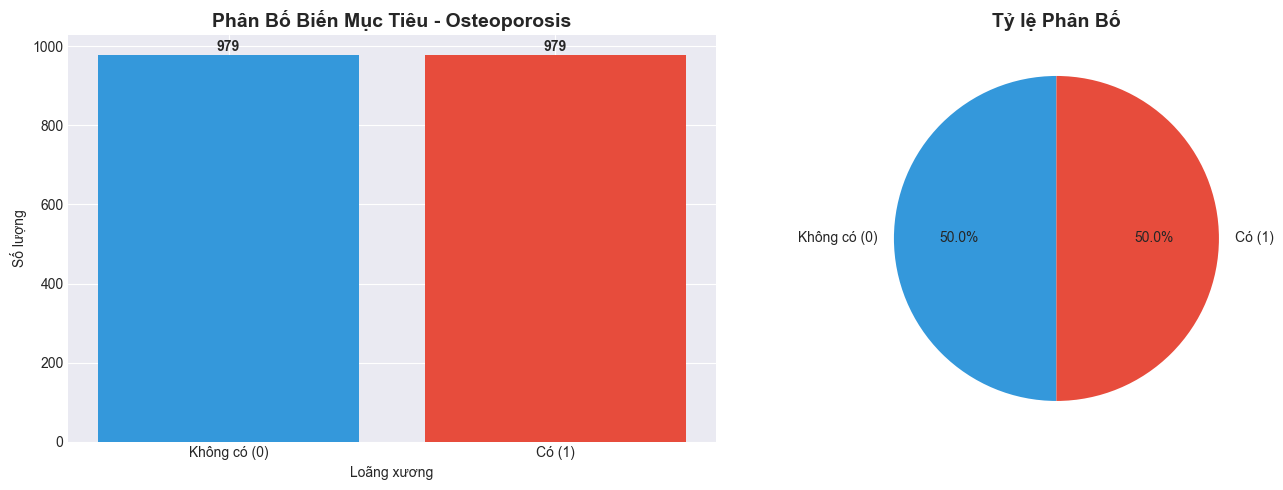


Dataset cân bằng: Có


In [31]:
# Kiểm tra phân bố của biến mục tiêu
print("=" * 60)
print("PHÂN BỐ BIẾN MỤC TIÊU (Osteoporosis)")
print("=" * 60)
target_counts = df['Osteoporosis'].value_counts()
print(target_counts)
print(f"\nTỷ lệ:")
print(target_counts / len(df) * 100)

# Vẽ biểu đồ phân bố
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(['Không có (0)', 'Có (1)'], target_counts.values, color=['#3498db', '#e74c3c'])
axes[0].set_title('Phân Bố Biến Mục Tiêu - Osteoporosis', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Số lượng')
axes[0].set_xlabel('Loãng xương')
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(target_counts.values, labels=['Không có (0)', 'Có (1)'], 
            autopct='%1.1f%%', startangle=90, colors=['#3498db', '#e74c3c'])
axes[1].set_title('Tỷ lệ Phân Bố', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nDataset cân bằng: {'Có' if abs(target_counts[0] - target_counts[1]) < 50 else 'Không'}")


## 2. Chuẩn bị Dữ liệu cho Training


In [33]:
# Tách features và target
X = df.drop('Osteoporosis', axis=1)
y = df['Osteoporosis']

print("=" * 60)
print("CHUẨN BỊ DỮ LIỆU")
print("=" * 60)
print(f"Shape của X (features): {X.shape}")
print(f"Shape của y (target): {y.shape}")
print(f"\nSố lượng features: {X.shape[1]}")

# Chuyển đổi boolean sang int (nếu cần)
if X.dtypes.any() == bool:
    X = X.astype(int)
    print("\nĐã chuyển đổi boolean sang int")

# Train/Test Split (70/30) - theo phương pháp Holdout trong tài liệu
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"\nPhân bố target trong train set:")
print(y_train.value_counts())
print(f"\nPhân bố target trong test set:")
print(y_test.value_counts())


CHUẨN BỊ DỮ LIỆU
Shape của X (features): (1958, 29)
Shape của y (target): (1958,)

Số lượng features: 29

Train set: 1370 samples (70.0%)
Test set: 588 samples (30.0%)

Phân bố target trong train set:
Osteoporosis
1    685
0    685
Name: count, dtype: int64

Phân bố target trong test set:
Osteoporosis
1    294
0    294
Name: count, dtype: int64


## 3. Xây dựng Mô hình Logistic Regression

Theo tài liệu (Chương 4, trang 11-24):
- Sử dụng Sigmoid function: hθ(X) = 1/(1 + e^(-θTX))
- Decision boundary: hθ(X) ≥ 0.5 → y=1, ngược lại y=0
- Cost function: -ylog(hθ(x)) - (1-y)log(1-hθ(x))


In [34]:
# Xây dựng mô hình Logistic Regression
print("=" * 60)
print("XÂY DỰNG MÔ HÌNH LOGISTIC REGRESSION")
print("=" * 60)

# Tạo mô hình với các tham số
# max_iter: số lần lặp tối đa cho gradient descent
# random_state: để đảm bảo kết quả có thể tái lập
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs'  # Thuật toán tối ưu
)

# Huấn luyện mô hình
print("Đang huấn luyện mô hình...")
lr_model.fit(X_train, y_train)
print("Hoàn thành huấn luyện!")

# Dự đoán
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]  # Xác suất lớp 1

print(f"\nSố lượng hệ số (coefficients): {len(lr_model.coef_[0])}")
print(f"Intercept (θ0): {lr_model.intercept_[0]:.4f}")
print(f"\nMột số hệ số đầu tiên:")
for i, coef in enumerate(lr_model.coef_[0][:5]):
    print(f"  Feature {i+1} ({X.columns[i]}): {coef:.4f}")


XÂY DỰNG MÔ HÌNH LOGISTIC REGRESSION
Đang huấn luyện mô hình...
Hoàn thành huấn luyện!

Số lượng hệ số (coefficients): 29
Intercept (θ0): 0.1241

Một số hệ số đầu tiên:
  Feature 1 (Age_Scaled): 3.4897
  Feature 2 (Gender_Female): -0.0103
  Feature 3 (Gender_Male): 0.1284
  Feature 4 (Hormonal Changes_Normal): 0.0159
  Feature 5 (Hormonal Changes_Postmenopausal): 0.1022


## 4. Đánh giá Mô hình

Theo tài liệu (Chương 4, trang 73-75):
- Accuracy: Độ chính xác tổng thể
- Precision: P = TP / (TP + FP)
- Recall: R = TP / (TP + FN)
- F1-Score: F1 = 2*P*R / (P + R)


In [35]:
# Tính các metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=" * 60)
print("KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"ROC-AUC:   {roc_auc:.4f} ({roc_auc*100:.2f}%)")

# Classification Report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Không có', 'Có']))


KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH
Accuracy:  0.8010 (80.10%)
Precision: 0.8498 (84.98%)
Recall:    0.7313 (73.13%)
F1-Score:  0.7861 (78.61%)
ROC-AUC:   0.8704 (87.04%)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Không có       0.76      0.87      0.81       294
          Có       0.85      0.73      0.79       294

    accuracy                           0.80       588
   macro avg       0.81      0.80      0.80       588
weighted avg       0.81      0.80      0.80       588



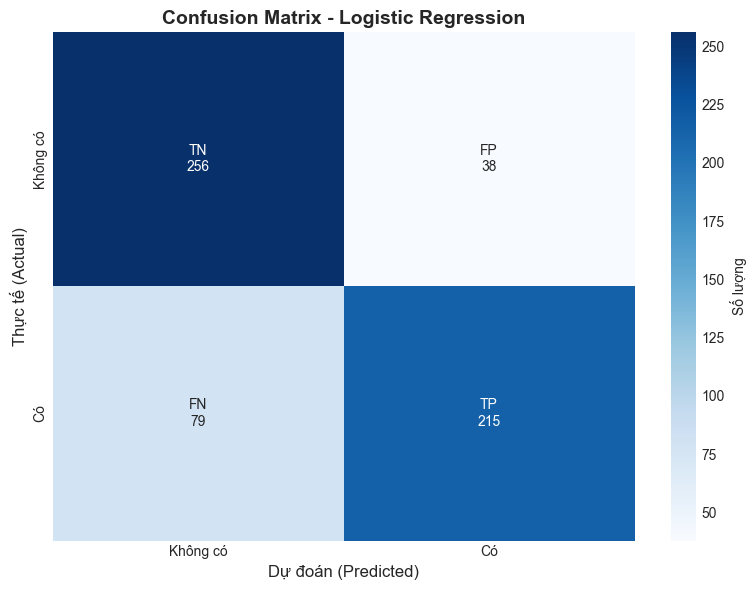


Chi tiết Confusion Matrix:
True Negative (TN):  256 - Dự đoán đúng 'Không có'
False Positive (FP): 38 - Dự đoán sai 'Có' (thực tế 'Không có')
False Negative (FN): 79 - Dự đoán sai 'Không có' (thực tế 'Có')
True Positive (TP):   215 - Dự đoán đúng 'Có'


In [37]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
annot_labels = np.array([
    [f"TN\n{TN}", f"FP\n{FP}"],
    [f"FN\n{FN}", f"TP\n{TP}"]
])

# Vẽ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=annot_labels,
    fmt='',
    cmap='Blues',
    xticklabels=['Không có', 'Có'],
    yticklabels=['Không có', 'Có'],
    cbar_kws={'label': 'Số lượng'}
)
ax.set_title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
ax.set_ylabel('Thực tế (Actual)', fontsize=12)
ax.set_xlabel('Dự đoán (Predicted)', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nChi tiết Confusion Matrix:")
print(f"True Negative (TN):  {TN} - Dự đoán đúng 'Không có'")
print(f"False Positive (FP): {FP} - Dự đoán sai 'Có' (thực tế 'Không có')")
print(f"False Negative (FN): {FN} - Dự đoán sai 'Không có' (thực tế 'Có')")
print(f"True Positive (TP):   {TP} - Dự đoán đúng 'Có'")


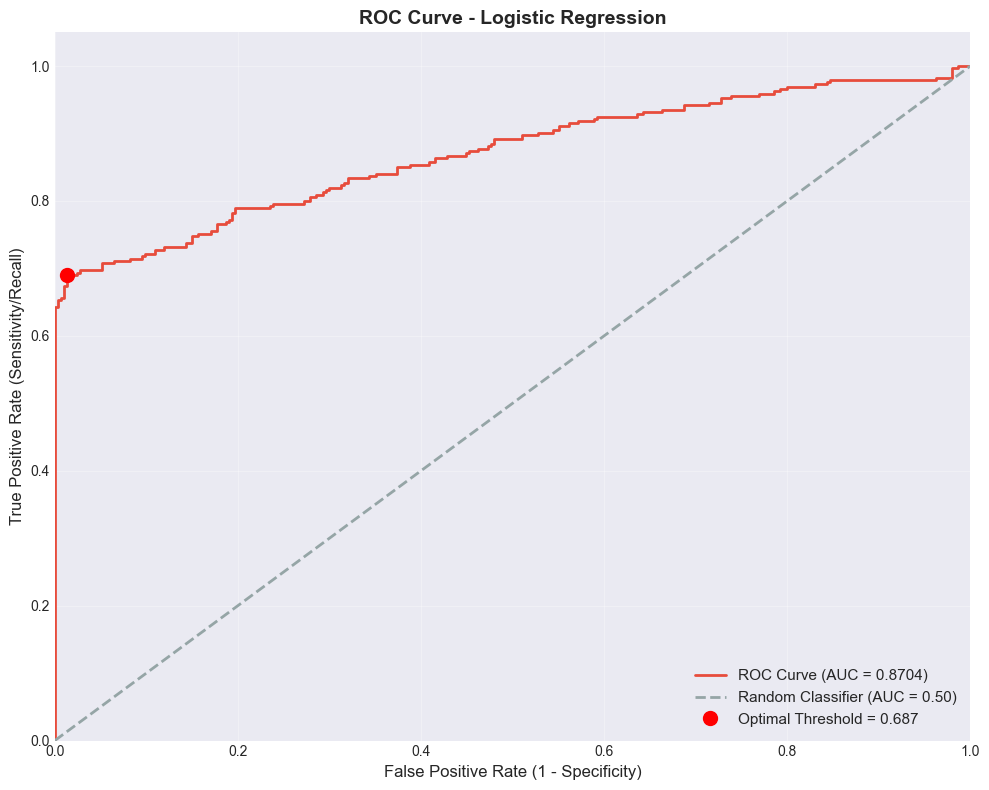

Optimal Threshold: 0.6872
Tại threshold này: TPR = 0.6905, FPR = 0.0136


In [38]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Vẽ ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='#95a5a6', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
plt.title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)

# Thêm điểm optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10, 
         label=f'Optimal Threshold = {optimal_threshold:.3f}')

plt.legend(loc="lower right", fontsize=11)
plt.tight_layout()
plt.show()

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Tại threshold này: TPR = {tpr[optimal_idx]:.4f}, FPR = {fpr[optimal_idx]:.4f}")


## 5. Phân tích Feature Importance (Hệ số)

Theo tài liệu, hệ số (coefficients) trong Logistic Regression cho biết tác động của từng feature đến kết quả dự đoán.


TOP 15 FEATURES QUAN TRỌNG NHẤT
                           Feature  Coefficient  Abs_Coefficient
                        Age_Scaled     3.489701         3.489701
          Race/Ethnicity_Caucasian     0.183867         0.183867
                        Smoking_No     0.174926         0.174926
          Alcohol Consumption_None     0.170456         0.170456
       Physical Activity_Sedentary     0.132915         0.132915
                       Gender_Male     0.128414         0.128414
           Body Weight_Underweight     0.124902         0.124902
               Prior Fractures_Yes     0.118983         0.118983
Medical Conditions_Hyperthyroidism     0.104981         0.104981
   Hormonal Changes_Postmenopausal     0.102236         0.102236
   Race/Ethnicity_African American    -0.081563         0.081563
           Calcium Intake_Adequate     0.081222         0.081222
       Vitamin D Intake_Sufficient     0.076851         0.076851
                Family History_Yes     0.071712         0.

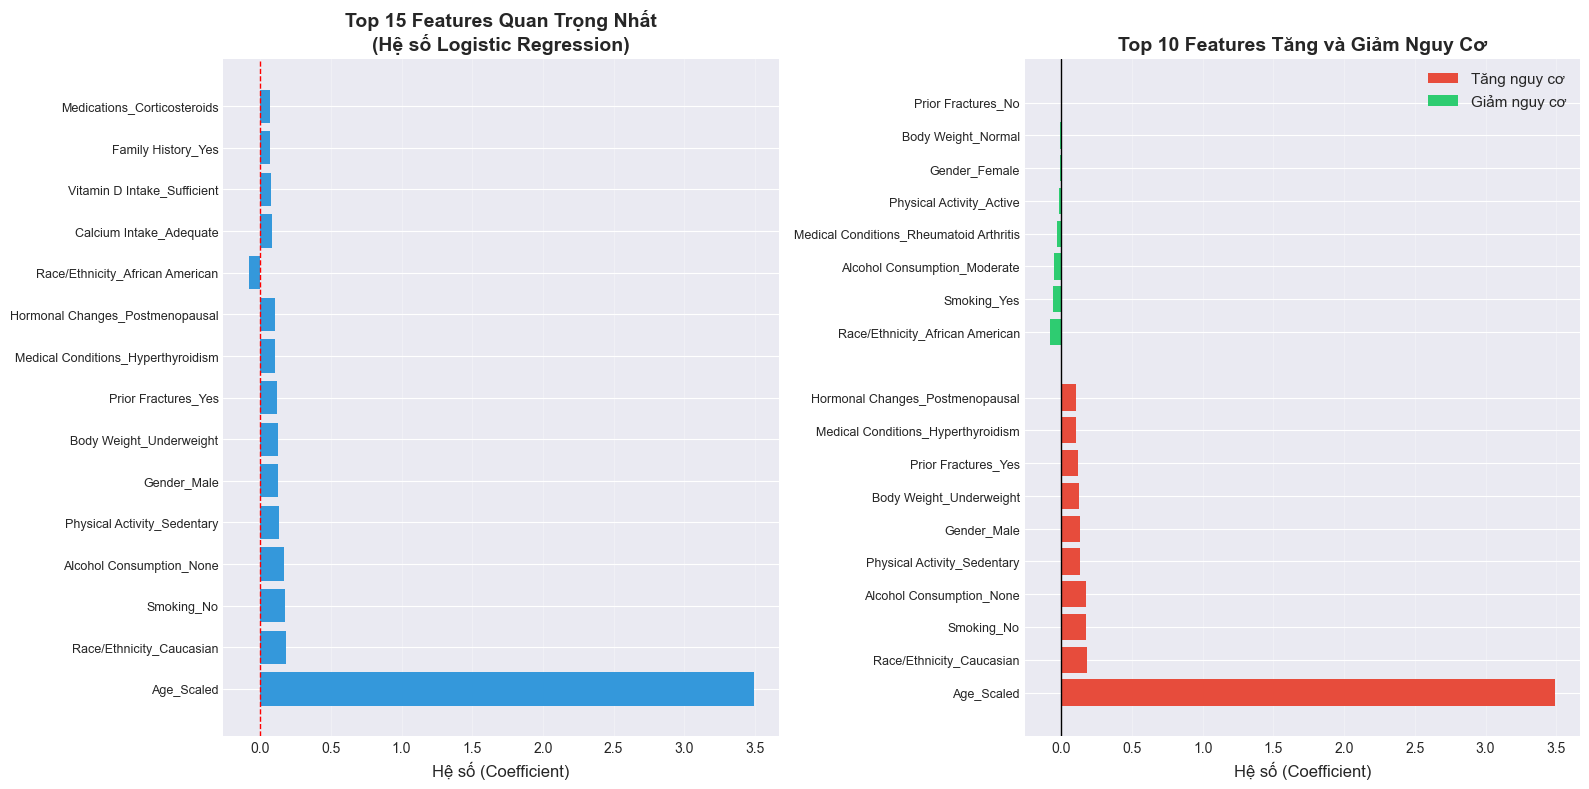


Giải thích:
- Hệ số dương: Feature này làm TĂNG nguy cơ Osteoporosis
- Hệ số âm: Feature này làm GIẢM nguy cơ Osteoporosis
- Giá trị tuyệt đối lớn: Feature quan trọng hơn


In [39]:
# Lấy hệ số và sắp xếp theo giá trị tuyệt đối
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("=" * 60)
print("TOP 15 FEATURES QUAN TRỌNG NHẤT")
print("=" * 60)
print(coefficients.head(15).to_string(index=False))

# Vẽ biểu đồ Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 15 features
top_features = coefficients.head(15)
axes[0].barh(range(len(top_features)), top_features['Coefficient'], color='#3498db')
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'], fontsize=9)
axes[0].set_xlabel('Hệ số (Coefficient)', fontsize=12)
axes[0].set_title('Top 15 Features Quan Trọng Nhất\n(Hệ số Logistic Regression)', 
                  fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3, axis='x')

# Top 10 features (dương và âm)
top_positive = coefficients[coefficients['Coefficient'] > 0].head(10)
top_negative = coefficients[coefficients['Coefficient'] < 0].head(10)

y_pos_pos = np.arange(len(top_positive))
y_pos_neg = np.arange(len(top_negative)) + len(top_positive) + 1

axes[1].barh(y_pos_pos, top_positive['Coefficient'], color='#e74c3c', label='Tăng nguy cơ')
axes[1].barh(y_pos_neg, top_negative['Coefficient'], color='#2ecc71', label='Giảm nguy cơ')
axes[1].set_yticks(list(y_pos_pos) + list(y_pos_neg))
axes[1].set_yticklabels(list(top_positive['Feature']) + list(top_negative['Feature']), fontsize=9)
axes[1].set_xlabel('Hệ số (Coefficient)', fontsize=12)
axes[1].set_title('Top 10 Features Tăng và Giảm Nguy Cơ', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nGiải thích:")
print(f"- Hệ số dương: Feature này làm TĂNG nguy cơ Osteoporosis")
print(f"- Hệ số âm: Feature này làm GIẢM nguy cơ Osteoporosis")
print(f"- Giá trị tuyệt đối lớn: Feature quan trọng hơn")


## 6. Phân tích Xác suất Dự đoán


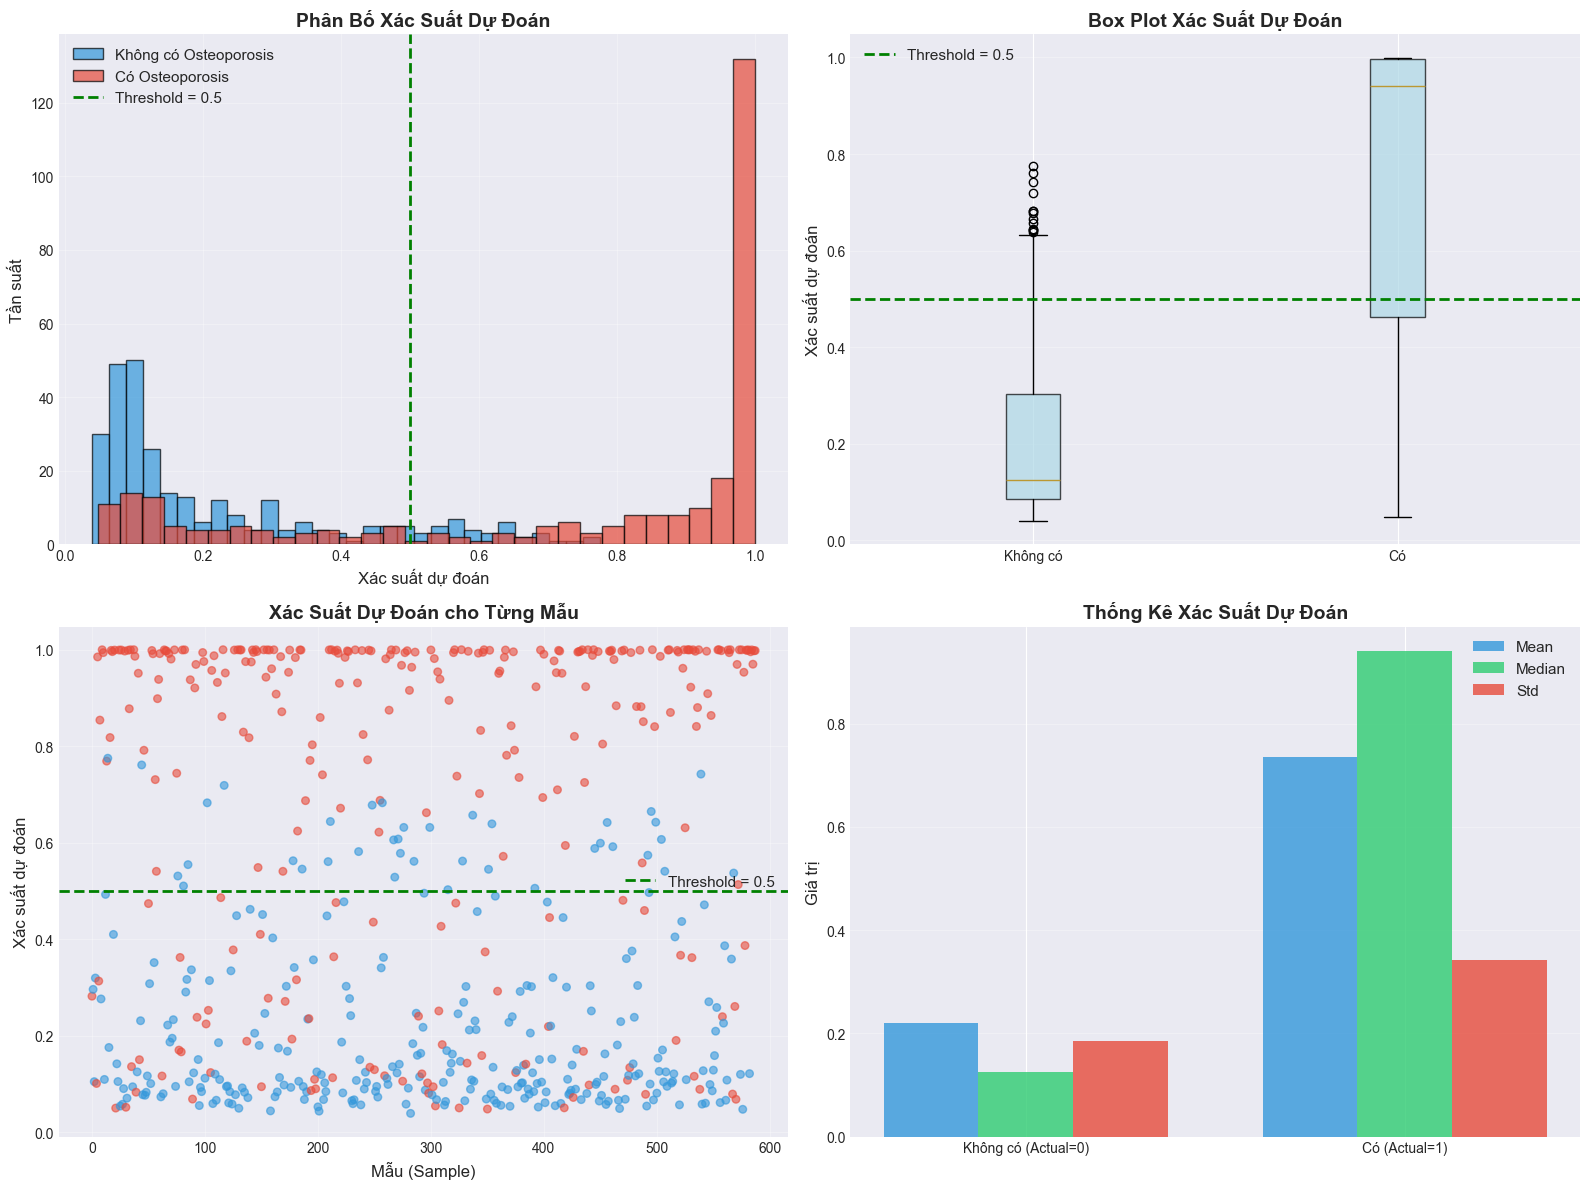

Thống kê xác suất dự đoán:
               Nhóm     Mean   Median      Std
Không có (Actual=0) 0.219430 0.125487 0.185353
      Có (Actual=1) 0.734237 0.940919 0.341358


In [40]:
# Phân tích phân bố xác suất dự đoán
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram của xác suất dự đoán
axes[0, 0].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, 
                label='Không có Osteoporosis', color='#3498db', edgecolor='black')
axes[0, 0].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, 
                label='Có Osteoporosis', color='#e74c3c', edgecolor='black')
axes[0, 0].axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Threshold = 0.5')
axes[0, 0].set_xlabel('Xác suất dự đoán', fontsize=12)
axes[0, 0].set_ylabel('Tần suất', fontsize=12)
axes[0, 0].set_title('Phân Bố Xác Suất Dự Đoán', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot so sánh
data_to_plot = [y_pred_proba[y_test == 0], y_pred_proba[y_test == 1]]
axes[0, 1].boxplot(data_to_plot, labels=['Không có', 'Có'], patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[0, 1].axhline(y=0.5, color='green', linestyle='--', linewidth=2, label='Threshold = 0.5')
axes[0, 1].set_ylabel('Xác suất dự đoán', fontsize=12)
axes[0, 1].set_title('Box Plot Xác Suất Dự Đoán', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. So sánh Actual vs Predicted
comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Probability': y_pred_proba
})

# Scatter plot
colors = ['#3498db' if a == 0 else '#e74c3c' for a in comparison_df['Actual']]
axes[1, 0].scatter(range(len(comparison_df)), comparison_df['Probability'], 
                   c=colors, alpha=0.6, s=30)
axes[1, 0].axhline(y=0.5, color='green', linestyle='--', linewidth=2, label='Threshold = 0.5')
axes[1, 0].set_xlabel('Mẫu (Sample)', fontsize=12)
axes[1, 0].set_ylabel('Xác suất dự đoán', fontsize=12)
axes[1, 0].set_title('Xác Suất Dự Đoán cho Từng Mẫu', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# 4. Thống kê xác suất theo nhóm
stats_df = pd.DataFrame({
    'Nhóm': ['Không có (Actual=0)', 'Có (Actual=1)'],
    'Mean': [y_pred_proba[y_test == 0].mean(), y_pred_proba[y_test == 1].mean()],
    'Median': [np.median(y_pred_proba[y_test == 0]), np.median(y_pred_proba[y_test == 1])],
    'Std': [y_pred_proba[y_test == 0].std(), y_pred_proba[y_test == 1].std()]
})

x = np.arange(len(stats_df['Nhóm']))
width = 0.25
axes[1, 1].bar(x - width, stats_df['Mean'], width, label='Mean', color='#3498db', alpha=0.8)
axes[1, 1].bar(x, stats_df['Median'], width, label='Median', color='#2ecc71', alpha=0.8)
axes[1, 1].bar(x + width, stats_df['Std'], width, label='Std', color='#e74c3c', alpha=0.8)
axes[1, 1].set_ylabel('Giá trị', fontsize=12)
axes[1, 1].set_title('Thống Kê Xác Suất Dự Đoán', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(stats_df['Nhóm'], fontsize=10)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Thống kê xác suất dự đoán:")
print(stats_df.to_string(index=False))


## 7. Tóm tắt và Kết luận


In [41]:
# Tóm tắt kết quả
print("=" * 60)
print("TÓM TẮT KẾT QUẢ MÔ HÌNH LOGISTIC REGRESSION")
print("=" * 60)
print("\nMETRICS:")
print(f"   - Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   - Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"   - Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"   - F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"   - ROC-AUC:   {roc_auc:.4f} ({roc_auc*100:.2f}%)")

print("\nCONFUSION MATRIX:")
print(f"   - True Positive (TP):  {TP} - Dự đoán đúng 'Có Osteoporosis'")
print(f"   - True Negative (TN):  {TN} - Dự đoán đúng 'Không có'")
print(f"   - False Positive (FP): {FP} - Dự đoán sai 'Có' (thực tế 'Không có')")
print(f"   - False Negative (FN): {FN} - Dự đoán sai 'Không có' (thực tế 'Có')")

print("\nTOP 5 FEATURES QUAN TRỌNG NHẤT:")
for idx, row in coefficients.head(5).iterrows():
    direction = "TĂNG" if row['Coefficient'] > 0 else "GIẢM"
    print(f"   {idx+1}. {row['Feature']}: {row['Coefficient']:.4f} ({direction} nguy cơ)")

print("\nĐÁNH GIÁ:")
if accuracy > 0.7:
    print("   - Mô hình có độ chính xác tốt (>70%)")
else:
    print("   - Mô hình cần cải thiện độ chính xác")

if roc_auc > 0.8:
    print("   - Mô hình phân biệt tốt giữa 2 lớp (ROC-AUC > 0.8)")
elif roc_auc > 0.7:
    print("   - Mô hình phân biệt khá tốt (ROC-AUC > 0.7)")
else:
    print("   - Mô hình cần cải thiện khả năng phân biệt")

if abs(precision - recall) < 0.1:
    print("   - Precision và Recall cân bằng tốt")
else:
    print("   - Có sự mất cân bằng giữa Precision và Recall")

print("\nKẾT LUẬN:")
print("   Mô hình Logistic Regression đã được xây dựng thành công.")
print("   Mô hình có thể được sử dụng để dự đoán nguy cơ loãng xương")
print("   dựa trên các yếu tố lối sống và đặc điểm cá nhân.")
print("   Các yếu tố quan trọng nhất đã được xác định thông qua")
print("   phân tích hệ số (coefficients).")


TÓM TẮT KẾT QUẢ MÔ HÌNH LOGISTIC REGRESSION

METRICS:
   - Accuracy:  0.8010 (80.10%)
   - Precision: 0.8498 (84.98%)
   - Recall:    0.7313 (73.13%)
   - F1-Score:  0.7861 (78.61%)
   - ROC-AUC:   0.8704 (87.04%)

CONFUSION MATRIX:
   - True Positive (TP):  215 - Dự đoán đúng 'Có Osteoporosis'
   - True Negative (TN):  256 - Dự đoán đúng 'Không có'
   - False Positive (FP): 38 - Dự đoán sai 'Có' (thực tế 'Không có')
   - False Negative (FN): 79 - Dự đoán sai 'Không có' (thực tế 'Có')

TOP 5 FEATURES QUAN TRỌNG NHẤT:
   1. Age_Scaled: 3.4897 (TĂNG nguy cơ)
   10. Race/Ethnicity_Caucasian: 0.1839 (TĂNG nguy cơ)
   19. Smoking_No: 0.1749 (TĂNG nguy cơ)
   22. Alcohol Consumption_None: 0.1705 (TĂNG nguy cơ)
   18. Physical Activity_Sedentary: 0.1329 (TĂNG nguy cơ)

ĐÁNH GIÁ:
   - Mô hình có độ chính xác tốt (>70%)
   - Mô hình phân biệt tốt giữa 2 lớp (ROC-AUC > 0.8)
   - Có sự mất cân bằng giữa Precision và Recall

KẾT LUẬN:
   Mô hình Logistic Regression đã được xây dựng thành công.
   